In [1]:
import numpy as np
from matplotlib import pyplot as plt
from cmath import pi,acos,exp,sqrt
def plotArc(ax,P0,n0,l,da,*args,tol=0.001,**kwargs):
  if l==0:
    return
  x=np.linspace(0,l,max(2,int(abs(6*(da/(2*pi)))),int(l//(2*abs(2*l/da*tol)**0.5)+1))if (da!=0) and (l!=0) else 2)
  phi2=x/l*da/2
  p=P0+x*np.sinc(phi2/pi)*n0*np.exp(1j*phi2)
  ax.plot(p.real,p.imag,*args,**kwargs)
    
def plotArcchain(ax,P0,n0,arcs,*args,**kwargs):
    p=P0
    n=n0
    for l,da in arcs:
        plotArc(ax,p,n,l,da,*args,**kwargs)
        p+=l*np.sinc(da/(2*pi))*n*exp(1j*da/2)
        n*=exp(1j*da)



In [2]:
from itertools import takewhile

#from bisect import bisect_right
def bisect_right(a,x,lo=0,hi=None):
    if hi is None:
        hi = len(a)
    while lo < hi:
        mid = (lo + hi) // 2
        if x < a[mid]:
            hi = mid
        else:
            lo = mid + 1
    return lo

def index_frac(x,ax):
    idx=bisect_right(ax,x,1,len(ax)-1)
    return idx-1,(x-ax[idx-1])/(ax[idx]-ax[idx-1])
    
def interp(x,ax,ay):
    idx=bisect_right(ax,x,1,len(ax)-1)
    return ay[idx-1]+(x-ax[idx-1])/(ax[idx]-ax[idx-1])*(ay[idx]-ay[idx-1])

def cumsum(x,x_start=None):
    if x_start!=None:
        csum=[x_start]+x.copy()
    else:
        csum=x.copy()
    for i in range(1,len(csum)):
        csum[i]+=csum[i-1]
    return csum
        

In [3]:
#interpSegments, Segments2Complex
import numpy as np
from matplotlib import pyplot as plt
from numpy import pi,exp,sign,inf

def polygonArea(p):
  def crossprod(v1,v2):
    return v1.real*v2.imag-v2.real*v1.imag
  return 0.5*np.sum(crossprod(p[range(-1,len(p)-1)],p))

def SegmentsLength(Segs):
    return sum(l for l,*_ in Segs)

def SegmentsArea(Segs):
  nSegs=len(Segs)
  dl,dang,*opts=np.array(Segs).transpose()
  ang=np.cumsum(dang)
  ang=exp(1j*np.insert( ang,0,0))
  dang_2=np.exp(1j*dang/2)
  viSeg=np.sinc(dang/(2*pi))*dl*dang_2*ang[:-1]
  pSeg=np.cumsum(viSeg)
  olderr=np.geterr()
  np.seterr(divide='ignore',invalid='ignore')#suppress the warnings from 0/0 = nan. nansum assumes nan=0, which is the correct value in this case
  area=polygonArea(pSeg) +  np.nansum((dl/dang)**2*(dang/2.0-dang_2.real*dang_2.imag))
  np.seterr(**olderr)
  return area

def InterpSegments(Segs,t,p0=0.+0.j,a0=0+1j,scale=1.0,eps=1e-6):
  """
  Segment points are calculated for values of 't', where 't' is the normalized
  length of the path. t is in the range of [0..1[
  """
  dl,dang=np.array([(l,a) for l,a,*_ in Segs]).transpose()
  L=np.cumsum(np.insert(dl,0,0.0))
  ang_=np.cumsum(np.insert(dang,0,0.0))
  ang=exp(1j*ang_)
  viSeg=np.sinc(dang/(2*pi))*dl*scale*np.exp(1j*dang/2)*ang[:-1]
  pSeg=np.cumsum(np.insert(viSeg,0,0+0j))
  if not hasattr(t,'__getitem__'): #not an array
    t=np.array([t]) #convert to array
  else:
    if t.shape==(): #no dimensions
      t=np.array([t])
    else:
      t=np.array(t)
  T=t.astype(int)
#  t=t-T
  if ((abs(pSeg[-1])<eps) and (abs(ang[-1]-(1+0j))<eps)):
    pr,ar=np.zeros((len(t),),dtype=complex), np.ones((len(t),),dtype=complex) # closed loop. No translation/rotation necessary for t>1
  else: #endpoint of path != startpoint => repeat path for t>1 by translating and rotating it
    def rotateSecant(v,beta,T):
      beta2=beta/2
      rot2=exp(1j*beta2)
      uniqueT,inverseIndex=np.unique(T,return_inverse=True) #don't re-calculate for identical values of T
      p=(v*rot2**(uniqueT-1)/nsinc(beta2/np.pi) * uniqueT * np.sinc(uniqueT*beta2/np.pi))[inverseIndex]
      a=(rot2**(2*uniqueT))[inverseIndex]
      return p,a
    pr,ar=rotateSecant(pSeg[-1]*a0,ang_[-1],T)
  pr+=p0
  ar*=a0
  l=L/L[-1]
  Xx=np.interp(t-T,l,range(len(l)))
  X=np.maximum(0,np.minimum(Xx.astype(int),len(dang)-1)) #segment index
  x=Xx-X#within seggment
  p=pSeg[X] + np.sinc( dang[X]*x /(2*pi))* dl[X]*x *scale*np.exp(1j* dang[X]*x /2)*ang[X]
  p=p*ar+pr
  a=ang[X]*np.exp(1j*dang[X]*x)*ar
  if len(p)==1:
      p=p[0] #convert array to single value if argument was a single value
      a=a[0]
  return p,a,L[-1]*t,X

def Segments2Complex(Segs,p0=0.+0.j,a0=1,scale=1.0,tol=0.05,offs=0,loops=1,return_start=False):
  """
  The parameter "tol defines the resolution. It is the maximum allowable
  difference between circular arc segment, and the secant between the
  calculated points on the arc. Smaller values for tol will result in
  more points per segment.
  """
  a=a0
  p=p0
  p-=1j*a*offs
  L=0
  if return_start:
      yield p,a,L,-1 #assuming closed loop: start-point = end-point
  loopcount=0
  while (loops==None) or (loops==inf) or (loopcount<loops):
      loopcount+=1
      for X,(l,da,*_) in enumerate(Segs):
        l=l*scale
        if da!=0:
          r=l/da
          r+=offs
          if r!=0:
            l=r*da
            dl=2*abs(2*r*tol)**0.5
            n=max(int(abs(6*(da/(2*pi)))),int(l//dl)+1)
          else:
            n=1
          dda=exp(1j*da/n)
          dda2=dda**0.5
          v=(2*r*dda2.imag)*dda2*a
        else:
          n=1
          dda=1
          v=l*a
        for i in range(n):
          L+=l/n
          p+=v
          yield p,a,L,X
          v*=dda
          a*=dda


In [4]:
def subdivide(l,maxdl,pc=0,r=None):
    """ 
    Add points to all line segments that intersect a circle with radius `r` around the center point `pc` 
    until no line segment in this region is longer than `maxdl`.
    
    Arguments: 
    l:complex   = iterable list of points that define the path
    maxdl:float = maximum length of a line segment => insert points if a line segment is longer
    pc:complex  = center point of circle  
    r:float     = radius of circle that defines the affected region
    
    Result: 
    <generator>:complex = generator that returns all original points, plus additional interpolated points 
                          in the specified circular region around `pc`.
    """
    l_start=next(l)
    for l_end in l:
        yield l_start
        dl=l_end-l_start
        absdl=abs(dl)
        if absdl<maxdl:
            l_start=l_end
            continue #no need to calculate anything else
        edl=dl/absdl
        x0=0
        x1=absdl 
        if r!=None:
          rr=(pc-l_start)/edl
          if (abs(rr.imag)<r): 
              dx=(r*r-rr.imag*rr.imag)**0.5
              x0=max(rr.real-dx,x0)
              x1=min(rr.real+dx,x1)
          else:
              x1=-1 #circle does not intersect
        if x1>x0:
          dx=x1-x0
          n=int(dx//maxdl)+1
          ddx=(dx/n)*edl
          x=x0*edl+l_start
          if x0>0:
            yield x  
          for _ in range(1,n):
            x+=ddx
            yield x
          if x1<absdl:
            yield x1*edl+l_start
        l_start=l_end
    yield l_start
tenderize=subdivide

In [5]:
def subdivide(l,maxdl=None,pc=0,r=None):
    """ 
    Add points to all line segments that intersect a circle with radius `r` around the center point `pc` 
    until no line segment in this region is longer than `maxdl`.
    
    Arguments: 
    l:complex   = iterable list of points that define the path
    maxdl:float = maximum length of a line segment => insert points if a line segment is longer
    pc:complex  = center point of circle  
    r:float     = radius of circle that defines the affected region
    
    Result: 
    <generator>:complex = generator that returns all original points, plus additional interpolated points 
                          in the specified circular region around `pc`.
    """
    if maxdl==None:
        yield from l
        return
    l_start=next(l)
    for l_end in l:
        yield l_start
        dl=l_end-l_start
        absdl=abs(dl)
        if absdl<maxdl:
            l_start=l_end
            continue #no need to calculate anything else
        edl=dl/absdl
        x0=0
        x1=absdl 
        if r!=None:
          rr=(pc-l_start)/edl
          if (abs(rr.imag)<r): 
              dx=(r*r-rr.imag*rr.imag)**0.5
              x0=max(rr.real-dx,x0)
              x1=min(rr.real+dx,x1)
          else:
              x1=-1 #circle does not intersect
        if x1>x0:
          dx=x1-x0
          n=int(dx//maxdl)+1
          ddx=(dx/n)*edl
          x=x0*edl+l_start
          if x0>0:
            yield x  
          for _ in range(1,n):
            x+=ddx
            yield x
          if x1<absdl:
            yield x1*edl+l_start
        l_start=l_end
    yield l_start
tenderize=subdivide

In [6]:
def radial_expand(l,pc,ro,ri=0):
    """
    Clear a circle by pushing the points outward, away from the center point `pc`.
    
    Arguments: 
    l:complex  = iterable list of points
    pc:complex = center point of circle  
    ro:float   = radius of circle that defines the affected points
    ri:float   = radius of circle that is cleared by pushing the points towards `ro`
    
    Result: 
    <generator>:complex = generator that returns the transformed points
    """
    for p in l:
        r=p-pc
        absr=abs(r)
        if absr<ro:
            p=pc+r/absr*((ri+(ro-ri)*absr/ro))
        yield p
pierce=radial_expand

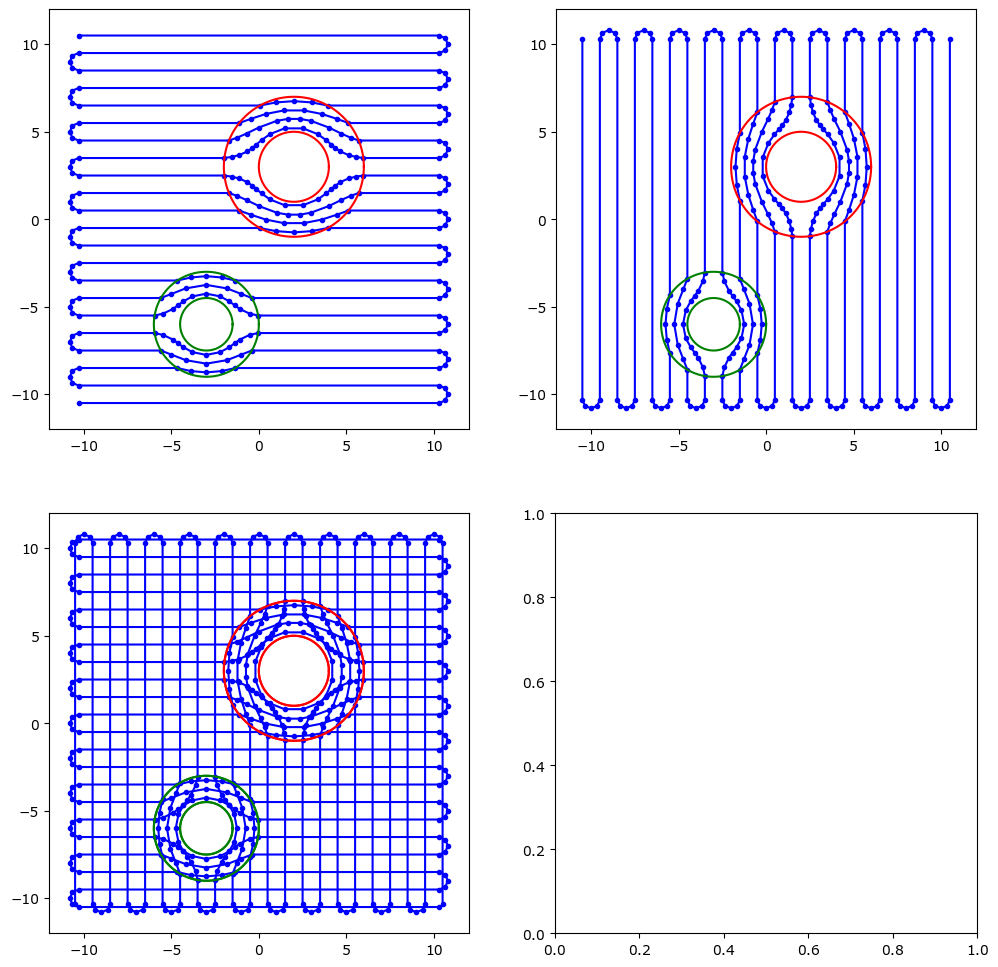

In [7]:
arcs=[[20.6,0],[0.5*pi,pi]]
arcs+=[[l,-da] for l,da in arcs] 
arcs*=11
p0=-10.3-10.5j
a0=1
pc1=2+3j
ro1=4
ri1=2.001
maxdl=1.0
pc2=-3-6j
ri2=1.5
ro2=3.0
pc,ri,ro=pc1,ri1,ro1
ew=0.5
#point source:
S1=lambda phi=0,**kwargs:Segments2Complex(arcs[:-1],p0*1j**phi, a0*1j**phi,return_start=True,**kwargs)
paLX2p=lambda g,dzdL=0,X2ew=lambda X:ew,**kwargs:(p for p,a,L,X in g)
#Transformations:
T1=lambda g,maxdl=maxdl,pc=pc,ro=ro,**kwargs: tenderize(g,maxdl=0.25*maxdl,pc=pc,r=0.3*ro)
T2=lambda g,maxdl=maxdl,pc=pc,ro=ro,**kwargs: tenderize(g,maxdl=0.5*maxdl,pc=pc,r=0.4*ro)
T3=lambda g,maxdl=maxdl,pc=pc,ro=ro,**kwargs: tenderize(g,maxdl=maxdl,pc=pc,r=ro)
T4=lambda g,pc=pc,ri=ri,ro=ro,**kwargs: pierce(g,pc=pc,ri=ri,ro=ro)
T5=lambda g,A=1,n=1:(A*p**n for p in g)
T=lambda g,**kwargs:T4(T3(T2(T1(g,**kwargs),**kwargs),**kwargs),**kwargs)
Tp2xy=lambda g:([p.real,p.imag] for p in g)
fig,axs=plt.subplots(2,2,figsize=(12,12))
for i,ax in enumerate([*axs[0],axs[1,0],axs[1,0]]) : 
  ax.plot(*list(zip(*Tp2xy(T5(T(T(paLX2p(S1(phi=-i)),pc=pc1,ri=ri1),pc=pc2,ri=ri2,ro=ro2))))),'b.-')
  for pc,ri,ro,c  in ((pc1,ri1,ro1,'r-'),(pc2,ri2,ro2,'g-')):  
    plotArc(ax,pc+ro,1j,ro*2*pi,2*pi,c)
    plotArc(ax,pc+ri,1j,ri*2*pi,2*pi,c)
  ax.set_aspect('equal')
  ax.set_xlim((-12,12))
  ax.set_ylim((-12,12))

/private/var/containers/Bundle/Application/7C9DD17F-16A9-4711-B339-5C06C1ECFE11/Carnets-sci.app/Library/lib/python3.11/site-packages/matplotlib/cbook.py:1698: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/private/var/containers/Bundle/Application/7C9DD17F-16A9-4711-B339-5C06C1ECFE11/Carnets-sci.app/Library/lib/python3.11/site-packages/matplotlib/cbook.py:1344: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


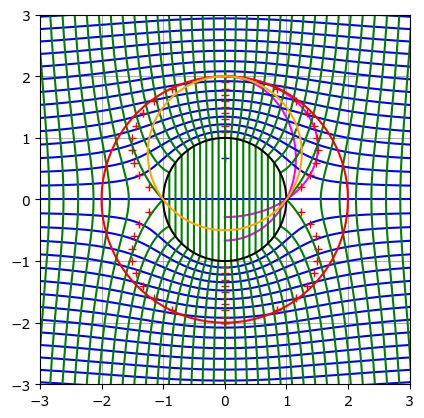

In [8]:
#r=np.linspace(0.001,20,10000)
theta=np.linspace(0.0005,pi-0.0005,1000)
co=np.cos(theta)
si=np.sin(theta)
psi=0.1
R=1
U=1
Ri=R
Ro=2*R
Rb=Ri
ei=Rb*Ro**2/(Ri*(2*Rb*Ro - Ri**2))
ai=ei*Ri
bi=(ai*Ri)**0.5
plt.plot(si*bi,Ro-ai*(1-co),'magenta')
e0=1.135
Rb=Ro
e0=Rb*Ro**2/(Ri*(2*Rb*Ro - Ri**2))
ao=e0*Ri
bo=(ao*Ro)**0.5
plt.plot(si*bo,Ro-ao*(1-co),'magenta')
ymin=Ro-2*ao
ymax=Ro
def xel(y,Ro,Ri,Rb,e):
  a=e*Ri
  b=(a*Rb)**0.5
  ymin=Ro-2*a
  ymax=Ro
  y_=(y-ymin)/(a)-1
  x=b*(1-y_**2)**0.5
  return x
pci=0+1j*(Ro-ai)
plt.plot(pci.real,pci.imag,'b+')
for psi in np.arange(0.2,3.1,0.2): 
  a=1.0
  b=-psi/(U*si)
  c=-R*R
  r=(-b+(b*b-4*a*c)**0.5)/2
  plt.plot(co*r,si*r,'b')
  plt.plot(co*r,-si*r,'b')
  y_=(psi-ymin)/(ao)-1
  if abs(y_)<=1: 
    x=bo*(1-y_**2)**0.5
    x=xel(psi,Ro,Ri,Ro,e0)
    p0=0+1j*(psi*(Ro-Ri)/Ro+Ri)
    p1=x+1j*psi
    p0i=p0-pci
    p1i=p1-pci
    p0i_=p0i.real/bi+p0i.imag/ai
    p1i_=p1i.real/bi+p1i.imag/ai
    plt.plot((x,x,-x,-x,p0.real, p0.real) ,(psi,-psi,psi,-psi,p0.imag,-p0.imag),'r+')
plt.plot((-3,3),(0,0),'b')
#r=4*theta*(1-0.45*theta)
#plt.plot(co*r,2-si*r,'cyan')

#theta=np.linspace(-pi/2+0.0005,pi/2-0.0005,1000)
#co=np.cos(theta)
#si=np.sin(theta)
#for phi in np.arange(-3.2,0,0.2): 
#  r = (phi - (phi**2-4*(co*R*U)**2)**0.5) /(2*co*U)
#  plt.plot(co*r,si*r,'g')
#  plt.plot(-co*r,si*r,'g')
y=np.linspace(-3.5,3.5,1000)
for phi in np.arange(-3.2,-0.10,0.2): 
  theta=np.arctan(y/phi) 
  co=np.cos(theta)
  si=np.sin(theta)
  r = (phi - (phi**2-4*(co*R*U)**2+0j)**0.5) /(2*co*U)
  plt.plot(co*r,si*r,'g')
  plt.plot(-co*r,si*r,'g')
plt.plot((0,0),(-3,3),'g')
plotArc(plt.gca(),1,1j,2*pi,2*pi,'k')
plotArc(plt.gca(),2,1j,4*pi,2*pi,'r')
plotArc(plt.gca(),2j,-1,2.5*pi,2*pi,'orange')
plt.gca().set_aspect('equal')
plt.grid()
plt.xlim(-3,3);
plt.ylim(-3,3);

In [9]:
def delete_points(l,pc=0,r=0,add_border_points=True):
    """ 
    Delete points in a circle with radius `r` around the center point `pc` 
    Optionally, add points where the path intersects the circle.
    
    Arguments: 
    l:complex   = iterable list of points that define the path
    maxdl:float = maximum length of a line segment => insert points if a line segment is longer
    pc:complex  = center point of circle  
    r:float     = radius of circle that defines the affected region
    
    Result: 
    <generator>:complex = generator that returns the points that are not deleted.
    """
    l_start=next(l)
    for l_end in l:
        if abs(l_start-pc)>r:
          yield l_start
        dl=l_end-l_start
        absdl=abs(dl)
        edl=dl/absdl
        x0=0     #default, if start and end points are outside the circle
        x1=absdl #  "
        if r>0: 
          rr=(pc-l_start)/edl
          if (abs(rr.imag)<r): 
              dx=(r*r-rr.imag*rr.imag)**0.5
              x0=max(rr.real-dx,x0)
              x1=min(rr.real+dx,x1)
          else:
              x1=-1 #circle does not intersect
        if x1>x0:
          if x0>0 and add_border_points:
            yield x0*edl+l_start
          if x1<absdl and add_border_points:
            yield x1*edl+l_start
        l_start=l_end
    if abs(l_start-pc)>r:
      yield l_start

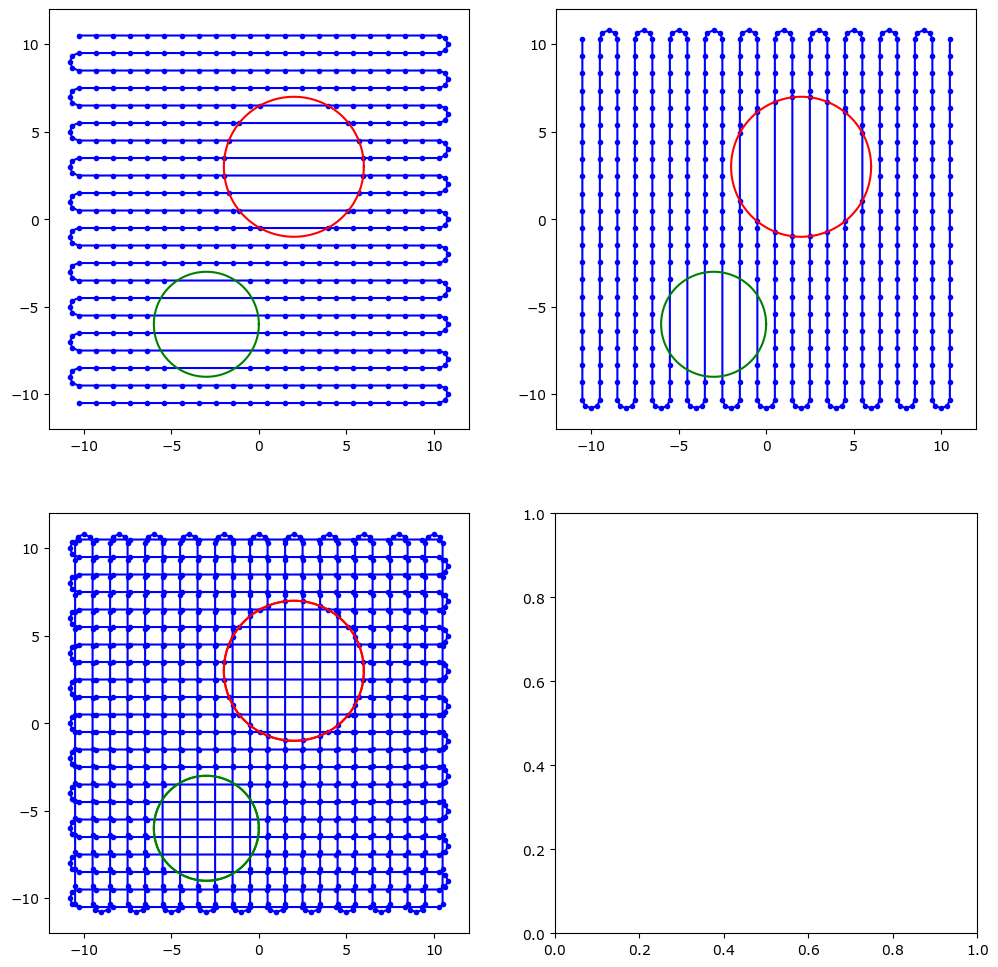

In [10]:
arcs=[[20.6,0],[0.5*pi,pi]]
arcs+=[[l,-da] for l,da in arcs] 
arcs*=11
p0=-10.3-10.5j
a0=1
pc1=2+3j
ro1=4
ri1=2.001
maxdl=1.0
pc2=-3-6j
ri2=1.5
ro2=3.0
pc,ri,ro=pc1,ri1,ro1
ew=0.5
#point source:
S1=lambda phi=0,**kwargs:Segments2Complex(arcs[:-1],p0*1j**phi, a0*1j**phi,return_start=True,**kwargs)
paLX2p=lambda g,dzdL=0,X2ew=lambda X:ew,**kwargs:(p for p,a,L,X in g)
#Transformations:
T1=lambda g,**kwargs: tenderize(g,**kwargs)
T2=lambda g,**kwargs: delete_points(g,**kwargs)
T=lambda g,**kwargs:T2(T1(g,**kwargs),**kwargs)
Tp2xy=lambda g:([p.real,p.imag] for p in g)
fig,axs=plt.subplots(2,2,figsize=(12,12))
for i,ax in enumerate([*axs[0],axs[1,0],axs[1,0]]) : 
  ax.plot(*list(zip(*Tp2xy(T2(T2(T1(paLX2p(S1(phi=-i)),maxdl=maxdl),pc=pc1,r=ro1),pc=pc2,r=ro2,add_border_points=False )))),'b.-')
  for pc,ri,ro,c  in ((pc1,ri1,ro1,'r-'),(pc2,ri2,ro2,'g-')):  
    plotArc(ax,pc+ro,1j,ro*2*pi,2*pi,c)
#    plotArc(ax,pc+ri,1j,ri*2*pi,2*pi,c)
  ax.set_aspect('equal')
  ax.set_xlim((-12,12))
  ax.set_ylim((-12,12))

In [11]:
import sympy as sy

def xel(y,Ro,Ri,Rb,e):
  a=e*Ri
  b=sy.sqrt(a*Rb)
  ymin=Ro-2*a
  ymax=Ro
  y_=(y-ymin)/(a)-1
  x=b*sy.sqrt(1-y_**2)
  return x

y,Ro,Ri,Rb,e=sy.symbols('y Ro Ri Rb e')
x=xel(0,Ro,Ri,Rb,e)
x=sy.sqrt((x**2).simplify())
print(sy.solve(x-Ri,e)[0].subs({Ro:2,Ri:1,Rb:1}))

4/3


(0.0, 2.5)

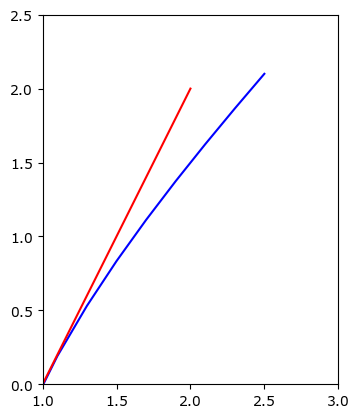

In [13]:
#r=np.linspace(0.001,20,10000)
phi=pi/2
co=np.cos(phi)
si=(1-co**2)**0.5
R=1
U=1
r=np.linspace(0.5,2.5,11 )
psi=U*(r-R*R/r)*si
plt.plot(r,psi,'b')
plt.plot((1,2),(0,2),'r')
plt.gca().set_aspect('equal')
plt.xlim(1,3);
plt.ylim(0,2.5)

In [ ]:
r

In [ ]:
chain=lambda *iterators:(value for iterator in iterators for value in iterator)
list(chain(range(10),range(5)))

In [ ]:
x=range(5)
print(list(x)) 
print(list(x))

In [ ]:
dir(range)

In [ ]:
Segments2Complex?

In [ ]:

list(subdivide(iter((0,2.6,4,4.2)),0.5))


In [ ]:
2.4//0.5

In [ ]:
g1(S1)
list(g1(S1()))